# Setup

Connect to Google Drive to Save the Model After Training

In [7]:
from google.colab import drive

drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


Please Ensure To Donwload the kaggle API token and upload it to the notebook. Do download the API token you should go to your kaggle account and generate a token from there.

In [8]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [9]:
!chmod 600 /root/.kaggle/kaggle.json

In [10]:
!kaggle datasets download -d johnowhitaker/opencities-masked-256

 99% 329M/331M [00:02<00:00, 158MB/s]
100% 331M/331M [00:02<00:00, 153MB/s]


In [11]:
!unzip '/content/opencities-masked-256.zip'

Streaming output truncated to the last 5000 lines.
  inflating: mid_train/data/images-256/acc_d41d81_58_19_261846_253991.png  
  inflating: mid_train/data/images-256/acc_d41d81_59_19_261847_253991.png  
  inflating: mid_train/data/images-256/acc_d41d81_5_19_261866_253986.png  
  inflating: mid_train/data/images-256/acc_d41d81_60_19_261848_253991.png  
  inflating: mid_train/data/images-256/acc_d41d81_61_19_261849_253991.png  
  inflating: mid_train/data/images-256/acc_d41d81_62_19_261850_253991.png  
  inflating: mid_train/data/images-256/acc_d41d81_63_19_261851_253991.png  
  inflating: mid_train/data/images-256/acc_d41d81_64_19_261857_253991.png  
  inflating: mid_train/data/images-256/acc_d41d81_65_19_261858_253991.png  
  inflating: mid_train/data/images-256/acc_d41d81_66_19_261859_253991.png  
  inflating: mid_train/data/images-256/acc_d41d81_67_19_261860_253991.png  
  inflating: mid_train/data/images-256/acc_d41d81_68_19_261861_253991.png  
  inflating: mid_train/data/images-256

In [12]:
import tensorflow as tf

device_name = tf.test.gpu_device_name()
if device_name != "/device:GPU:0":
    raise SystemError("GPU device not found")
print("Found GPU at: {}".format(device_name))

Found GPU at: /device:GPU:0


In [14]:
from keras.layers import (
    Input,
    Conv2D,
    MaxPooling2D,
    Conv2DTranspose,
    concatenate,
    UpSampling2D,
    Dropout,
)
from keras.models import Model
import keras.backend as K
from tensorflow.keras.preprocessing.image import load_img
import numpy as np
from sklearn.utils import shuffle

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import cv2

import os

# Load And Visualize Data

In [15]:
image_path1 = "/content/mid_train/data/images-256/"
image_path2 = "/content/mini_train/data/images-256/"
all_image_paths = [image_path1 + file for file in os.listdir(image_path1)] + [
    image_path2 + file for file in os.listdir(image_path2)
]

In [16]:
label_path1 = "/content/mid_train/data/masks-256/"
label_path2 = "/content/mini_train/data/masks-256/"
all_masks_paths = [label_path1 + file for file in os.listdir(label_path1)] + [
    label_path2 + file for file in os.listdir(label_path2)
]

In [17]:
len(all_image_paths)

3286

In [18]:
all_images_paths = sorted(all_image_paths)
all_masks_paths = sorted(all_masks_paths)

In [19]:
IMAGE_SIZE = 256


def open_images(paths):
    images = []
    for path in paths:
        image = load_img(path, target_size=(IMAGE_SIZE, IMAGE_SIZE))
        image = np.mean(image, axis=-1) / 255.0
        images.append(image)
    return np.array(images)

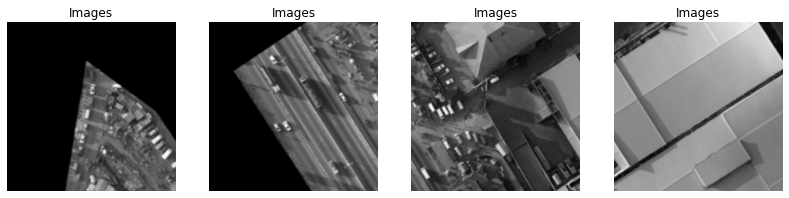

In [20]:
fig = plt.figure(figsize=(32, 32))
for i in range(1, 5):
    fig.add_subplot(3, 9, i)
    plt.axis("off")
    plt.title("Images")
    plt.imshow(open_images([all_images_paths[i - 1]])[0], cmap="gray")
plt.show()

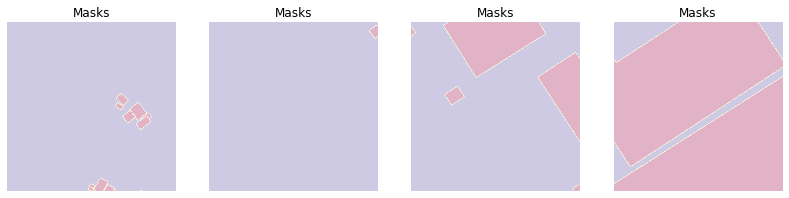

In [21]:
fig = plt.figure(figsize=(32, 32))
for i in range(1, 5):
    fig.add_subplot(3, 9, i)
    plt.axis("off")
    plt.title("Masks")
    plt.imshow(open_images([all_masks_paths[i - 1]])[0], cmap="Spectral_r", alpha=0.3)
plt.show()

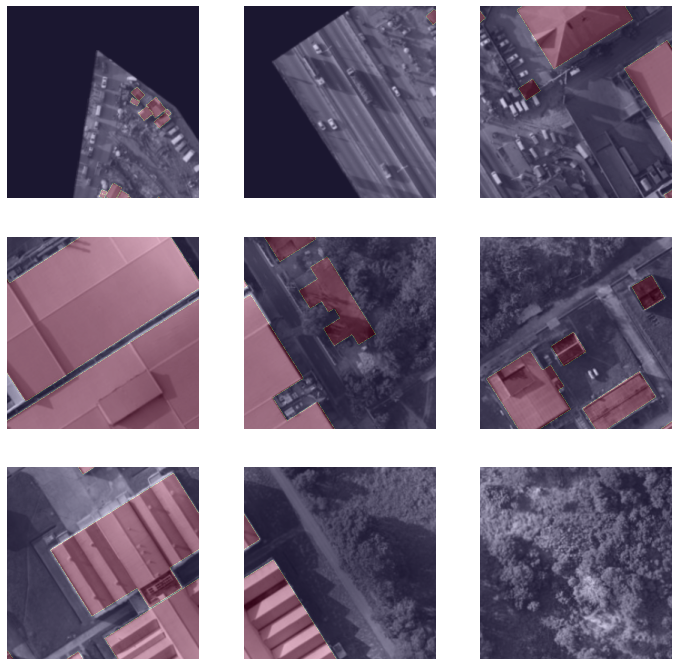

In [22]:
fig = plt.figure(figsize=(12, 12))
c = 3
r = 3
for i in range(1, c * r + 1):
    fig.add_subplot(r, c, i)
    plt.axis("off")
    plt.imshow(open_images([all_images_paths[i - 1]])[0], cmap="gray")
    plt.imshow(open_images([all_masks_paths[i - 1]])[0], cmap="Spectral_r", alpha=0.3)
plt.show()

In [23]:
all_images = open_images(all_images_paths)
all_masks = open_images(all_masks_paths)

In [25]:
all_images.shape

(3286, 256, 256)

In [24]:
all_masks.shape

(3286, 256, 256)

In [26]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    all_images, all_masks, test_size=0.25, random_state=0
)

In [27]:
X_train.shape

(2464, 256, 256)

In [28]:
X_test.shape

(822, 256, 256)

In [29]:
import gc

del all_images
del all_masks
gc.collect()

16081

# Train The Model

In [30]:
def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2.0 * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

In [31]:
def iou_coef(y_true, y_pred, smooth=1):
    intersection = K.sum(K.abs(y_true * y_pred), axis=[1, 2, 3])
    union = K.sum(y_true, [1, 2, 3]) + K.sum(y_pred, [1, 2, 3]) - intersection
    iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
    return iou

In [32]:
inputs = Input((None, None, 1))

c1 = Conv2D(8, (3, 3), activation="relu", padding="same")(inputs)
c1 = Conv2D(8, (3, 3), activation="relu", padding="same")(c1)
p1 = MaxPooling2D((2, 2))(c1)

c2 = Conv2D(16, (3, 3), activation="relu", padding="same")(p1)
c2 = Conv2D(16, (3, 3), activation="relu", padding="same")(c2)
p2 = MaxPooling2D((2, 2))(c2)

c3 = Conv2D(32, (3, 3), activation="relu", padding="same")(p2)
c3 = Conv2D(32, (3, 3), activation="relu", padding="same")(c3)
p3 = MaxPooling2D((2, 2))(c3)

c4 = Conv2D(64, (3, 3), activation="relu", padding="same")(p3)
c4 = Conv2D(64, (3, 3), activation="relu", padding="same")(c4)
p4 = MaxPooling2D(pool_size=(2, 2))(c4)

c5 = Conv2D(64, (3, 3), activation="relu", padding="same")(p4)
c5 = Conv2D(64, (3, 3), activation="relu", padding="same")(c5)
p5 = MaxPooling2D(pool_size=(2, 2))(c5)

c55 = Conv2D(128, (3, 3), activation="relu", padding="same")(p5)
c55 = Conv2D(128, (3, 3), activation="relu", padding="same")(c55)

u6 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding="same")(c55)
u6 = concatenate([u6, c5])
c6 = Conv2D(64, (3, 3), activation="relu", padding="same")(u6)
c6 = Conv2D(64, (3, 3), activation="relu", padding="same")(c6)

u71 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding="same")(c6)
u71 = concatenate([u71, c4])
c71 = Conv2D(32, (3, 3), activation="relu", padding="same")(u71)
c61 = Conv2D(32, (3, 3), activation="relu", padding="same")(c71)

u7 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding="same")(c61)
u7 = concatenate([u7, c3])
c7 = Conv2D(32, (3, 3), activation="relu", padding="same")(u7)
c7 = Conv2D(32, (3, 3), activation="relu", padding="same")(c7)

u8 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding="same")(c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(16, (3, 3), activation="relu", padding="same")(u8)
c8 = Conv2D(16, (3, 3), activation="relu", padding="same")(c8)

u9 = Conv2DTranspose(8, (2, 2), strides=(2, 2), padding="same")(c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(8, (3, 3), activation="relu", padding="same")(u9)
c9 = Conv2D(8, (3, 3), activation="relu", padding="same")(c9)

outputs = Conv2D(1, (1, 1), activation="sigmoid")(c9)

model = Model(inputs=[inputs], outputs=[outputs])
model.compile(
    optimizer="adam", loss="binary_crossentropy", metrics=[dice_coef, "accuracy"]
)

In [33]:
history = model.fit(X_train, y_train, validation_split=0.2, batch_size=16, epochs=30)

Epoch 1/30
124/124 [==============================] - 23s 96ms/step - loss: 0.5432 - dice_coef: 0.3462 - accuracy: 0.7210 - val_loss: 0.5105 - val_dice_coef: 0.4039 - val_accuracy: 0.7232
Epoch 2/30
124/124 [==============================] - 10s 80ms/step - loss: 0.4884 - dice_coef: 0.3882 - accuracy: 0.7317 - val_loss: 0.4879 - val_dice_coef: 0.4008 - val_accuracy: 0.7440
Epoch 3/30
124/124 [==============================] - 10s 80ms/step - loss: 0.4773 - dice_coef: 0.4073 - accuracy: 0.7453 - val_loss: 0.4712 - val_dice_coef: 0.4093 - val_accuracy: 0.7581
Epoch 4/30
124/124 [==============================] - 10s 81ms/step - loss: 0.4617 - dice_coef: 0.4357 - accuracy: 0.7604 - val_loss: 0.4687 - val_dice_coef: 0.4482 - val_accuracy: 0.7597
Epoch 5/30
124/124 [==============================] - 10s 82ms/step - loss: 0.4507 - dice_coef: 0.4514 - accuracy: 0.7690 - val_loss: 0.4501 - val_dice_coef: 0.4364 - val_accuracy: 0.7776
Epoch 6/30
124/124 [==============================] - 10s 84

# Plotting Learning Curves

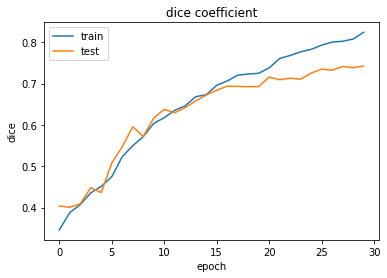

In [34]:
plt.plot(history.history["dice_coef"])
plt.plot(history.history["val_dice_coef"])
plt.title("dice coefficient")
plt.ylabel("dice")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")
plt.show()

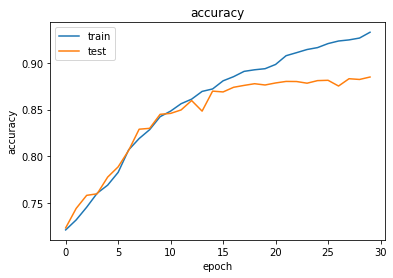

In [35]:
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.title("accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")
plt.show()

# Save Model For Inference

In [ ]:
path_to_save_json = "/content/gdrive/MyDrive/Omdena/OpenCities/model/model.json"
path_to_save_model = "/content/gdrive/MyDrive/Omdena/OpenCities/model/model.h5"
model_json = model.to_json()
with open(path_to_save_json, "w") as json_file:
    json_file.write(model_json)

model.save_weights(path_to_save_model)